Loading original Sentinel-2 data...
  B02: (763, 926) - CRS: EPSG:32610
  B03: (763, 926) - CRS: EPSG:32610
  B04: (763, 926) - CRS: EPSG:32610
  B08: (763, 926) - CRS: EPSG:32610

Loading super-resolved data...
  B02: (3052, 3704) - CRS: EPSG:32610
  B03: (3052, 3704) - CRS: EPSG:32610
  B04: (3052, 3704) - CRS: EPSG:32610
  B08: (3052, 3704) - CRS: EPSG:32610

Loading control points...
Control points: 6 points loaded
Control points CRS: EPSG:4326
Control points reprojected to: EPSG:32610

Extracting spectral values at control points...
Downsampling B02: factor_y=4.00, factor_x=4.00
Downsampling B03: factor_y=4.00, factor_x=4.00
Downsampling B04: factor_y=4.00, factor_x=4.00
Downsampling B08: factor_y=4.00, factor_x=4.00
Calculating quality metrics...

Calculating spatial quality metrics...
Generating plots...


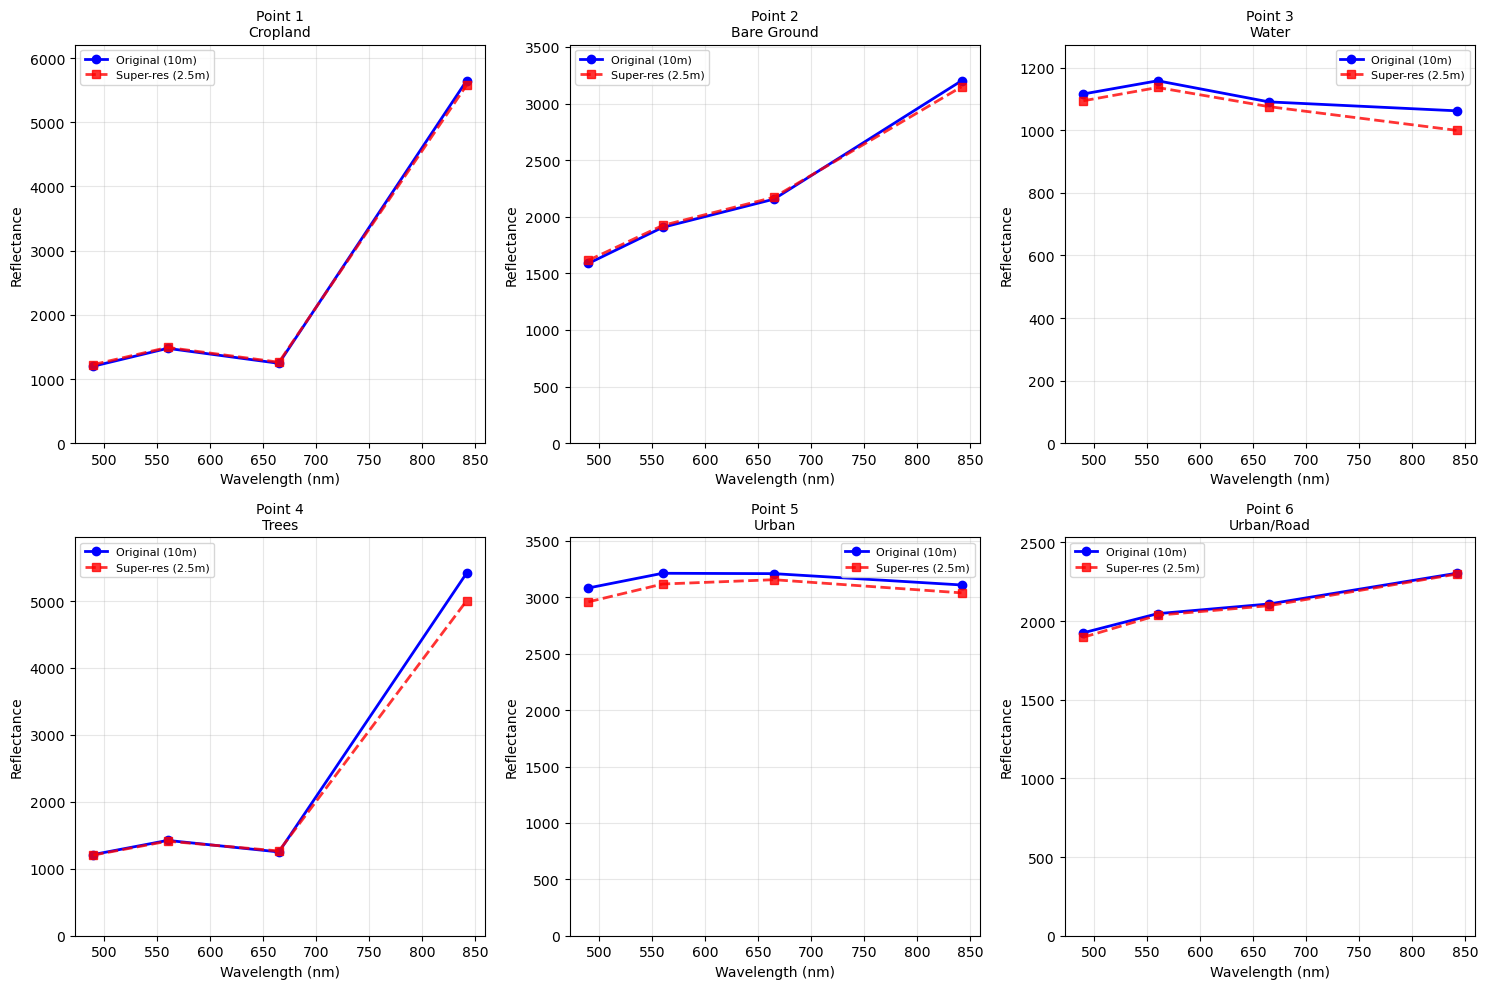

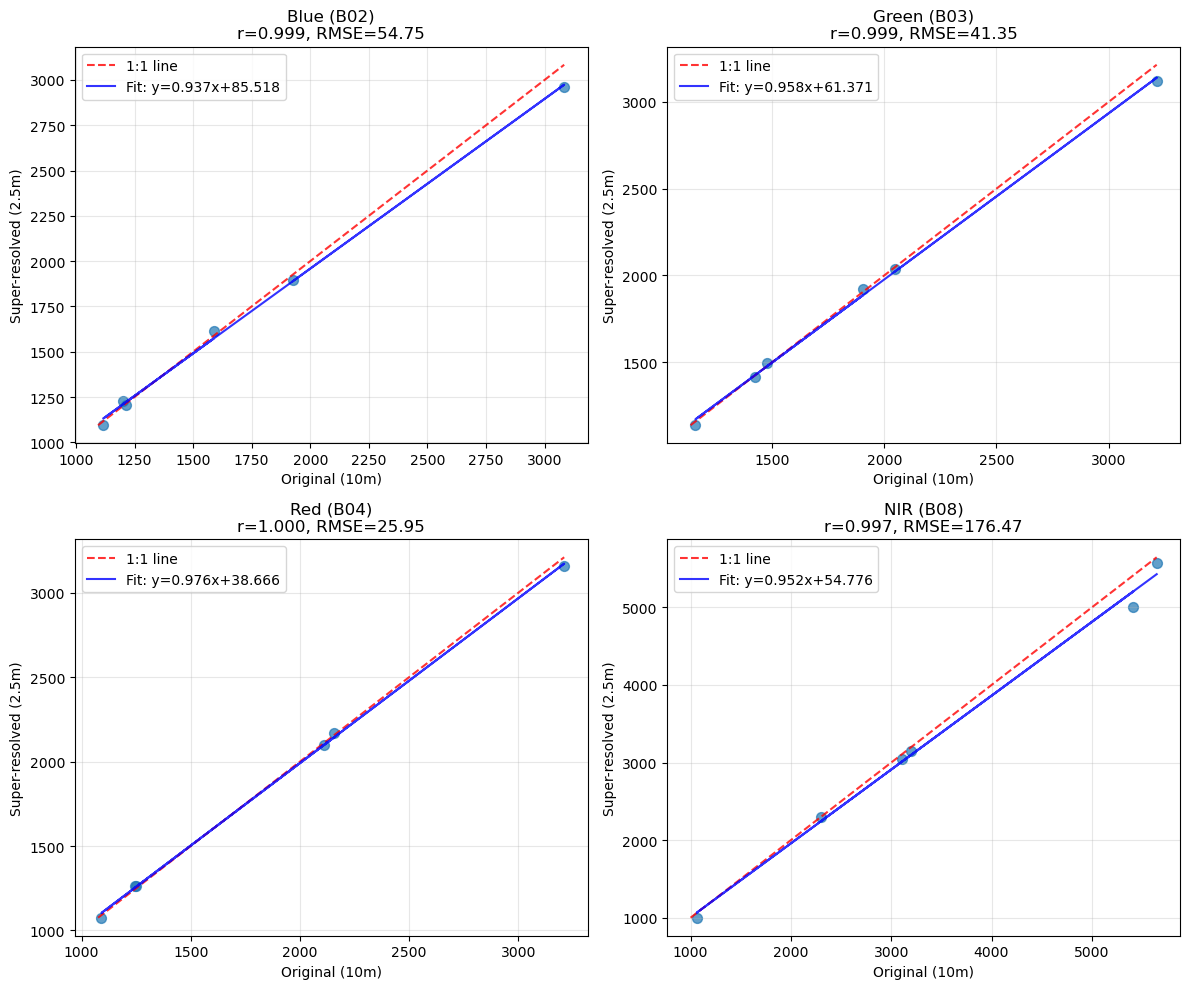


SENTINEL-2 SUPER-RESOLUTION QUALITY ASSESSMENT REPORT

SUMMARY STATISTICS:
       Band  Wavelength (nm) Correlation (r) P-value   RMSE    MAE    Bias RMSE (%) Edge Corr. Texture Corr.
 B02 (Blue)              490           0.999  0.0000  54.75  39.19  -21.44      3.2      0.339         0.797
B03 (Green)              560           0.999  0.0000  41.35  28.30  -17.81      2.2      0.278         0.784
  B04 (Red)              665           1.000  0.0000  25.95  21.46   -5.20      1.4      0.236         0.790
  B08 (NIR)              842           0.997  0.0000 176.47 112.31 -112.31      5.1      0.025         0.849

OVERALL ASSESSMENT:
Average Spectral Correlation: 0.999
Average Normalized RMSE: 3.0%
Super-resolution Quality: EXCELLENT

Report saved to: super_resolution_assessment_report.csv

Assessment completed successfully!
Generated files:
- spectral_profiles_comparison.png
- correlation_analysis.png
- super_resolution_assessment_report.csv


In [4]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import ndimage
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class SentinelSuperResolutionAssessment:
    def __init__(self):
        # Band names and wavelengths (nm)
        self.band_info = {
            'B02': {'name': 'Blue', 'wavelength': 490},
            'B03': {'name': 'Green', 'wavelength': 560},
            'B04': {'name': 'Red', 'wavelength': 665},
            'B08': {'name': 'NIR', 'wavelength': 842}
        }
        
        # File paths
        self.original_paths = {
            'B02': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\Sentinel_2\T10UEV_20240817T190911_sample_1_B02.jp2",
            'B03': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\Sentinel_2\T10UEV_20240817T190911_sample_1_B03.jp2",
            'B04': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\Sentinel_2\T10UEV_20240817T190911_sample_1_B04.jp2",
            'B08': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\Sentinel_2\T10UEV_20240817T190911_sample_1_B08.jp2"
        }
        
        self.superres_paths = {
            'B02': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\LuscidEye\T10UEV_20240817T190911_LuscidEye_sample_1_B02.jp2",
            'B03': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\LuscidEye\T10UEV_20240817T190911_LuscidEye_sample_1_B03.jp2",
            'B04': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\LuscidEye\T10UEV_20240817T190911_LuscidEye_sample_1_B04.jp2",
            'B08': r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\imgaery\LuscidEye\T10UEV_20240817T190911_LuscidEye_sample_1_B08.jp2"
        }
        
        self.control_points_path = r"Q:\dss_workarea\mlabiadh\workspace\20250813_luscidEye_imagery_assessement\control_points.shp"
        
        self.original_data = {}
        self.superres_data = {}
        self.control_points = None
        
    def load_data(self):
        """Load all raster data and control points"""
        print("Loading original Sentinel-2 data...")
        for band, path in self.original_paths.items():
            with rasterio.open(path) as src:
                self.original_data[band] = {
                    'data': src.read(1),
                    'transform': src.transform,
                    'crs': src.crs,
                    'bounds': src.bounds
                }
                print(f"  {band}: {self.original_data[band]['data'].shape} - CRS: {src.crs}")
        
        print("\nLoading super-resolved data...")
        for band, path in self.superres_paths.items():
            with rasterio.open(path) as src:
                self.superres_data[band] = {
                    'data': src.read(1),
                    'transform': src.transform,
                    'crs': src.crs,
                    'bounds': src.bounds
                }
                print(f"  {band}: {self.superres_data[band]['data'].shape} - CRS: {src.crs}")
        
        print("\nLoading control points...")
        self.control_points = gpd.read_file(self.control_points_path)
        print(f"Control points: {len(self.control_points)} points loaded")
        print(f"Control points CRS: {self.control_points.crs}")
        
        # Ensure control points are in the same CRS as the imagery
        if self.control_points.crs != self.original_data['B02']['crs']:
            self.control_points = self.control_points.to_crs(self.original_data['B02']['crs'])
            print(f"Control points reprojected to: {self.original_data['B02']['crs']}")
    
    def extract_pixel_values(self, x, y, data_dict, buffer_size=1):
        """Extract pixel values at given coordinates with optional buffer"""
        values = {}
        for band in data_dict.keys():
            # Convert coordinates to pixel indices
            transform = data_dict[band]['transform']
            col, row = ~transform * (x, y)
            col, row = int(col), int(row)
            
            # Extract value with buffer (average of surrounding pixels)
            if buffer_size > 0:
                data_array = data_dict[band]['data']
                min_row = max(0, row - buffer_size)
                max_row = min(data_array.shape[0], row + buffer_size + 1)
                min_col = max(0, col - buffer_size)
                max_col = min(data_array.shape[1], col + buffer_size + 1)
                
                subset = data_array[min_row:max_row, min_col:max_col]
                values[band] = np.mean(subset[subset > 0])  # Exclude no-data values
            else:
                values[band] = data_dict[band]['data'][row, col]
                
        return values
    
    def downsample_superres_to_original(self):
        """Downsample super-resolved data to original resolution for comparison"""
        downsampled = {}
        
        for band in self.superres_data.keys():
            # Calculate downsampling factor (should be 4x for 2.5m to 10m)
            original_shape = self.original_data[band]['data'].shape
            superres_shape = self.superres_data[band]['data'].shape
            
            factor_y = superres_shape[0] / original_shape[0]
            factor_x = superres_shape[1] / original_shape[1]
            
            print(f"Downsampling {band}: factor_y={factor_y:.2f}, factor_x={factor_x:.2f}")
            
            # Downsample using block averaging
            downsampled_data = ndimage.zoom(
                self.superres_data[band]['data'], 
                (1/factor_y, 1/factor_x), 
                order=1  # Bilinear interpolation
            )
            
            downsampled[band] = {
                'data': downsampled_data,
                'transform': self.original_data[band]['transform'],
                'crs': self.original_data[band]['crs']
            }
            
        return downsampled
    
    def extract_control_point_spectra(self):
        """Extract spectral values at all control points"""
        spectra_original = []
        spectra_superres = []
        point_ids = []
        
        # Downsample super-resolved data for fair comparison
        downsampled_superres = self.downsample_superres_to_original()
        
        for idx, point in self.control_points.iterrows():
            x, y = point.geometry.x, point.geometry.y
            point_id = getattr(point, 'id', idx) if hasattr(point, 'id') else idx
            cover_label = getattr(point, 'cover', 'Unknown') if hasattr(point, 'cover') else 'Unknown'
            
            # Extract from original data
            orig_values = self.extract_pixel_values(x, y, self.original_data, buffer_size=1)
            
            # Extract from downsampled super-resolved data
            superres_values = self.extract_pixel_values(x, y, downsampled_superres, buffer_size=1)
            
            # Store results
            spectra_original.append(orig_values)
            spectra_superres.append(superres_values)
            point_ids.append((point_id, cover_label))
        
        return spectra_original, spectra_superres, point_ids
    
    def plot_spectral_profiles(self, spectra_original, spectra_superres, point_ids):
        """Plot spectral profiles for all control points"""
        bands = list(self.band_info.keys())
        wavelengths = [self.band_info[band]['wavelength'] for band in bands]
        
        # Create 3 columns by 2 rows grid for 6 points
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Plot all points (should be 6 or fewer)
        n_points = len(point_ids)
        
        for i in range(n_points):
            ax = axes[i]
            
            orig_values = [spectra_original[i][band] for band in bands]
            superres_values = [spectra_superres[i][band] for band in bands]
            
            ax.plot(wavelengths, orig_values, 'o-', label='Original (10m)', 
                   linewidth=2, markersize=6, color='blue')
            ax.plot(wavelengths, superres_values, 's--', label='Super-res (2.5m)', 
                   linewidth=2, markersize=6, color='red', alpha=0.8)
            
            # Extract point ID and cover label
            point_id, cover_label = point_ids[i]
            ax.set_title(f'Point {point_id}\n{cover_label}', fontsize=10)
            ax.set_xlabel('Wavelength (nm)')
            ax.set_ylabel('Reflectance')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)
            
            # Set y-axis to reasonable range
            ax.set_ylim(0, max(max(orig_values), max(superres_values)) * 1.1)
        
        # Hide unused subplots
        for i in range(n_points, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('spectral_profiles_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def calculate_correlations_and_metrics(self, spectra_original, spectra_superres):
        """Calculate various quality metrics"""
        results = {}
        bands = list(self.band_info.keys())
        
        for band in bands:
            orig_values = [spectrum[band] for spectrum in spectra_original]
            superres_values = [spectrum[band] for spectrum in spectra_superres]
            
            # Remove any NaN or invalid values
            valid_indices = ~(np.isnan(orig_values) | np.isnan(superres_values))
            orig_clean = np.array(orig_values)[valid_indices]
            superres_clean = np.array(superres_values)[valid_indices]
            
            if len(orig_clean) > 1:
                # Pearson correlation
                r, p_value = pearsonr(orig_clean, superres_clean)
                
                # Other metrics
                rmse = np.sqrt(mean_squared_error(orig_clean, superres_clean))
                mae = mean_absolute_error(orig_clean, superres_clean)
                bias = np.mean(superres_clean - orig_clean)
                
                # Normalized metrics
                rmse_norm = rmse / np.mean(orig_clean) * 100  # RMSE as percentage of mean
                
                results[band] = {
                    'correlation': r,
                    'p_value': p_value,
                    'rmse': rmse,
                    'mae': mae,
                    'bias': bias,
                    'rmse_normalized': rmse_norm,
                    'n_points': len(orig_clean)
                }
        
        return results
    
    def plot_correlation_analysis(self, spectra_original, spectra_superres, correlation_results):
        """Plot correlation scatter plots and summary statistics"""
        bands = list(self.band_info.keys())
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for i, band in enumerate(bands):
            ax = axes[i]
            
            orig_values = [spectrum[band] for spectrum in spectra_original]
            superres_values = [spectrum[band] for spectrum in spectra_superres]
            
            # Remove NaN values
            valid_indices = ~(np.isnan(orig_values) | np.isnan(superres_values))
            orig_clean = np.array(orig_values)[valid_indices]
            superres_clean = np.array(superres_values)[valid_indices]
            
            # Scatter plot
            ax.scatter(orig_clean, superres_clean, alpha=0.7, s=50)
            
            # 1:1 line
            min_val = min(np.min(orig_clean), np.min(superres_clean))
            max_val = max(np.max(orig_clean), np.max(superres_clean))
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='1:1 line')
            
            # Fit line
            z = np.polyfit(orig_clean, superres_clean, 1)
            p = np.poly1d(z)
            ax.plot(orig_clean, p(orig_clean), 'b-', alpha=0.8, label=f'Fit: y={z[0]:.3f}x+{z[1]:.3f}')
            
            # Statistics
            r = correlation_results[band]['correlation']
            rmse = correlation_results[band]['rmse']
            
            ax.set_title(f'{self.band_info[band]["name"]} ({band})\n'
                        f'r={r:.3f}, RMSE={rmse:.2f}')
            ax.set_xlabel('Original (10m)')
            ax.set_ylabel('Super-resolved (2.5m)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def calculate_spatial_metrics(self):
        """Calculate spatial quality metrics"""
        print("\nCalculating spatial quality metrics...")
        
        spatial_results = {}
        
        for band in self.original_data.keys():
            orig_data = self.original_data[band]['data']
            superres_data = self.superres_data[band]['data']
            
            # Downsample super-resolved data
            downsampled = ndimage.zoom(superres_data, 
                                     (orig_data.shape[0]/superres_data.shape[0], 
                                      orig_data.shape[1]/superres_data.shape[1]), 
                                     order=1)
            
            # Calculate spatial metrics
            # Edge preservation (using Sobel filter)
            orig_edges = np.sqrt(ndimage.sobel(orig_data, axis=0)**2 + 
                               ndimage.sobel(orig_data, axis=1)**2)
            superres_edges = np.sqrt(ndimage.sobel(downsampled, axis=0)**2 + 
                                   ndimage.sobel(downsampled, axis=1)**2)
            
            edge_correlation = pearsonr(orig_edges.flatten(), 
                                      superres_edges.flatten())[0]
            
            # Texture preservation (using standard deviation in local windows)
            orig_texture = ndimage.generic_filter(orig_data, np.std, size=3)
            superres_texture = ndimage.generic_filter(downsampled, np.std, size=3)
            
            texture_correlation = pearsonr(orig_texture.flatten(), 
                                         superres_texture.flatten())[0]
            
            spatial_results[band] = {
                'edge_correlation': edge_correlation,
                'texture_correlation': texture_correlation
            }
        
        return spatial_results
    
    def generate_summary_report(self, correlation_results, spatial_results):
        """Generate a comprehensive summary report"""
        print("\n" + "="*60)
        print("SENTINEL-2 SUPER-RESOLUTION QUALITY ASSESSMENT REPORT")
        print("="*60)
        
        # Create summary dataframe
        summary_data = []
        for band in correlation_results.keys():
            row = {
                'Band': f"{band} ({self.band_info[band]['name']})",
                'Wavelength (nm)': self.band_info[band]['wavelength'],
                'Correlation (r)': f"{correlation_results[band]['correlation']:.3f}",
                'P-value': f"{correlation_results[band]['p_value']:.4f}",
                'RMSE': f"{correlation_results[band]['rmse']:.2f}",
                'MAE': f"{correlation_results[band]['mae']:.2f}",
                'Bias': f"{correlation_results[band]['bias']:.2f}",
                'RMSE (%)': f"{correlation_results[band]['rmse_normalized']:.1f}",
                'Edge Corr.': f"{spatial_results[band]['edge_correlation']:.3f}",
                'Texture Corr.': f"{spatial_results[band]['texture_correlation']:.3f}"
            }
            summary_data.append(row)
        
        df_summary = pd.DataFrame(summary_data)
        print("\nSUMMARY STATISTICS:")
        print(df_summary.to_string(index=False))
        
        # Overall assessment
        avg_correlation = np.mean([correlation_results[band]['correlation'] 
                                 for band in correlation_results.keys()])
        avg_rmse = np.mean([correlation_results[band]['rmse_normalized'] 
                          for band in correlation_results.keys()])
        
        print(f"\nOVERALL ASSESSMENT:")
        print(f"Average Spectral Correlation: {avg_correlation:.3f}")
        print(f"Average Normalized RMSE: {avg_rmse:.1f}%")
        
        # Quality assessment
        if avg_correlation > 0.9 and avg_rmse < 10:
            quality = "EXCELLENT"
        elif avg_correlation > 0.8 and avg_rmse < 15:
            quality = "GOOD"
        elif avg_correlation > 0.7 and avg_rmse < 25:
            quality = "FAIR"
        else:
            quality = "POOR"
        
        print(f"Super-resolution Quality: {quality}")
        
        # Save report
        df_summary.to_csv('super_resolution_assessment_report.csv', index=False)
        print(f"\nReport saved to: super_resolution_assessment_report.csv")
        
        return df_summary
    
    def run_assessment(self):
        """Run the complete assessment workflow"""
        try:
            # Load data
            self.load_data()
            
            # Extract spectral data at control points
            print("\nExtracting spectral values at control points...")
            spectra_original, spectra_superres, point_ids = self.extract_control_point_spectra()
            
            # Calculate correlation and quality metrics
            print("Calculating quality metrics...")
            correlation_results = self.calculate_correlations_and_metrics(
                spectra_original, spectra_superres)
            
            # Calculate spatial metrics
            spatial_results = self.calculate_spatial_metrics()
            
            # Generate plots
            print("Generating plots...")
            self.plot_spectral_profiles(spectra_original, spectra_superres, point_ids)
            self.plot_correlation_analysis(spectra_original, spectra_superres, correlation_results)
            
            # Generate summary report
            summary_df = self.generate_summary_report(correlation_results, spatial_results)
            
            return {
                'correlation_results': correlation_results,
                'spatial_results': spatial_results,
                'summary': summary_df,
                'spectra_original': spectra_original,
                'spectra_superres': spectra_superres,
                'point_ids': point_ids
            }
            
        except Exception as e:
            print(f"Error during assessment: {str(e)}")
            raise

def main():
    """Main execution function"""
    # Initialize assessment
    assessment = SentinelSuperResolutionAssessment()
    
    # Run the complete assessment
    results = assessment.run_assessment()
    
    print("\nAssessment completed successfully!")
    print("Generated files:")
    print("- spectral_profiles_comparison.png")
    print("- correlation_analysis.png") 
    print("- super_resolution_assessment_report.csv")
    
    return results

if __name__ == "__main__":
    results = main()